In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({"font.size": 8})

# Conformal Quantile Regression for estimation of Conditional Average Treatment Effect

As we've discussed in the post about [Conditional Density Estimation](https://vitaliset.github.io/conditional-density-estimation/), having a sense of confidence associated with your prediction is important for decision making <a href=#bibliography>[1]</a>, and this is no different in applications of causal inference. Here, estimating confidence intervals for the Conditional Average Treatment Effect (CATE) can greatly enhance the validity of causal inference studies.

In the binary treatment $T\in\{0, 1\}$ scenario, CATE is defined as the expected difference in outcomes $Y$ when an individual with certain observable characteristics is treated versus when the same individual is not treated. Mathematically, depending on the school of causal inference that you come from, we can write "the average difference in expected potential outcomes conditional on the same covariates $Z=z$" as <a href=#bibliography>[2, 3, 4]</a>

$$
\begin{align*}
    \textrm{CATE}_{T, Y}(z) &= \mathbb{E}(Y| do(T=1), Z=z) - \mathbb{E}(Y| do(T=0), Z)\\
    &= \mathbb{E}(Y_1 | Z=z) - \mathbb{E}(Y_0 | Z=z).
\end{align*}
$$

CATE helps to estimate the effect of a treatment at an individual level, taking into account the specific characteristics of each instance. This is incredibly valuable in many fields of industry where understanding the effect of a treatment ($T$) on different subpopulations ($Z$) helps in creating personalized treatment plans depending on the desired outcome ($Y$).

___

## Brief review of confounder control

It's common to use a set of variables satisfying the backdoor criterion in the CATE conditionals to measure the causal effect of $T$ on $Y$ or, in Rubin's theory, which renders $T$ conditionally ignorable to measure the causal effect on $Y$, i.e., $(Y_0, Y_1) \, \bot \, T \, | \, Z$. This is important because, in this scenario, $Z$ controls confounders <a href=#bibliography>[2]</a>, so

$$f(z|do(T=t)) = f(z)\textrm{, and }f(y|do(T=t), Z=z) = f(y|T=t, Z=z),$$

and consequently <a href=#bibliography>[2]</a>

$$\mathbb{E}(Y|do(T=t), Z) = \mathbb{E}(Y|T=t, Z=z).$$

This relationship is crucial as it enables us to estimate this quantity using any supervised machine learning model. This technique is known as the adjustment formula and has different flavors such as meta-learners and matching <a href=#bibliography>[2, 3]</a>.

Despite its utility, applying conformal prediction for estimating CATE in the above scenario is not straightforward. Since binary CATE involves estimating two quantities, it is necessary to combine the prediction intervals of these two estimates in some way. We will discuss how we can do this without any parametric assumptions.

$\oint$ _In continuous treatment scenarios, my experience has shown that $\mathbb{E}(Y| do(T=1), Z=z)$ provides more information than CATE, which is defined as the derivative of this expectation. It is easier to directly use conformal prediction in $\mathbb{E}(Y| do(T=1), Z=z)$ as this scenario can be interpreted just as a regression, when using the adjustment formula. On the other hand, if you realy need to use CATE, this interval estimate is much more complicated, and bootstrap strategies would be approach I would use. If you have another idea, please reach out!_

___

## Creating the dataset

To illustrate our application, we will use a simple causal graph where $Z$ will act as a confounder, serving as a set that satisfies the backdoor criterion.

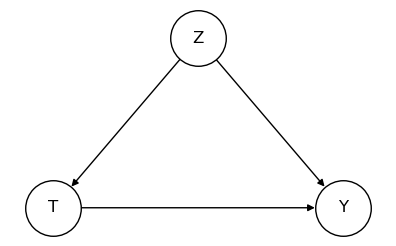

In [2]:
import networkx as nx

fig, ax = plt.subplots(figsize=(4, 2.5))
G = nx.DiGraph()
G.add_edges_from(
    [
        ("Z", "T"),
        ("Z", "Y"),
        ("T", "Y"),
    ]
)

pos = {"T": [-1, 0], "Z": [0, 0.6], "Y": [1, 0]}
nx.draw_networkx(
    G,
    pos,
    node_size=1600,
    node_color="w",
    edgecolors="k",
    with_labels=True,
    arrows=True,
    ax=ax,
)
ax.set_xlim(-1.3, 1.3)
ax.axis("off")
ax.set_ylim(-0.1, 0.7)
plt.tight_layout()

With structural causal graph given by

$$U_Z \sim \textrm{Uniform}(-\pi, \pi)\textrm{, with }g_Z(u_Z) = u_Z,$$

$$U_T \sim \textrm{Uniform}(0, 1)\textrm{, with }$$
$$g_T(u_T, z) = \mathbb{1}(u_T \leq 0.05 + 0.9\, \sigma(3z))\textrm{, where }\sigma(x) = \frac{1}{1 + \exp(-x)},$$

$$U_Y \sim \mathcal{N}(0, 1)\textrm{, with }$$
$$g_Y(u_Y, z, t) = \mathbb{1}(t=0) (10 \sin(z)) + \mathbb{1}(t=1) (10 \cos(z)) + 0.5 (1 + t\,|z|)\,u_Y.$$

Note that we are in a suitable scenario to apply causal inference as the positivity assumption <a href=#bibliography>[5]</a> is guaranteed; in other words, it holds that

$$ 0 < \mathbb{P}(T=t | Z=z) < 1 \textrm{, }\forall t \in \textrm{Im}(T)= \{ 0, 1\}, z \in \textrm{Im}(Z) = (0, 1).$$

In [3]:
def adapted_sigmoid(x):
    return 0.05 + 0.9 / (1 + np.exp(-x))

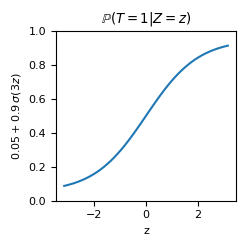

In [4]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(np.linspace(-np.pi, np.pi), adapted_sigmoid(np.linspace(-np.pi, np.pi)))
ax.set_ylim(0, 1)
ax.set_title("$\mathbb{P}(T=1 | Z=z)$")
ax.set_xlabel("z")
ax.set_ylabel("$0.05 + 0.9 \,\sigma(3z)$")
plt.tight_layout()

In [5]:
def func_0(Z):
    return 10 * np.sin(Z)

def func_1(Z):
    return 10 * np.cos(Z)

def generate_data(size=100, obs=True, random_state=None):
    rs = np.random.RandomState(random_state).randint(
        0, 2**32 - 1, dtype=np.int64, size=4
    )

    Z_obs = np.random.RandomState(rs[0]).uniform(low=-np.pi, high=np.pi, size=size)

    def g_T_noised(Z):
        return (
            np.random.RandomState(rs[1])
            .binomial(n=1, p=adapted_sigmoid(Z))
            .astype(bool)
        )

    T_obs = g_T_noised(Z_obs)

    noise = np.random.RandomState(rs[3]).normal(size=size)

    def g_Y(T, Z, noise):
        return (
            np.select(condlist=[T], choicelist=[func_1(Z)], default=func_0(Z))
            + 0.5 * (1 + T * np.abs(Z)) * noise
        )

    Y_obs = g_Y(T_obs, Z_obs, noise)
    Y_cf = g_Y(~T_obs, Z_obs, noise)

    def generate_df(T, Z, Y):
        return pd.DataFrame(
            np.vstack([T.astype(int), Z, Y]).T,
            columns=["treatment", "confounder", "target"],
        )

    df_obs = generate_df(T_obs, Z_obs, Y_obs)
    df_cf = generate_df(~T_obs, Z_obs, Y_cf)

    return df_obs, df_cf

df_obs, df_cf = generate_data(size=50_000, obs=True, random_state=42)

Since we are dealing with synthetic data, we can observe both the observational and the counterfactual scenarios. In this instance, we can actually derive $Y_1 - Y_0$ for each example. Thus, we will be able to evaluate our estimates using a test set that's separate from the training set, as is typical in supervised scenarios.

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df_obs.assign(target_cf=df_cf.target),
    test_size=0.2,
    random_state=42,
)

df_train_t0 = df_train.query("treatment == 0")
df_train_t1 = df_train.query("treatment == 1")

def return_XZ_y(df, backdoor_set_list):
    return df.filter(backdoor_set_list), np.array(df.target)

backdoor_set = ["confounder"]

XZ_train_t0, y_train_t0 = return_XZ_y(df_train_t0, backdoor_set)
XZ_train_t1, y_train_t1 = return_XZ_y(df_train_t1, backdoor_set)

XZ_test, y_test = return_XZ_y(df_test, backdoor_set)

___

## Positivity assumption

One assumption, often overlooked in Pearl's theory but crucial to test for good estimation, is the positivity assumption. As we observed earlier, this assumption is satisfied in our synthetic data, but in a real-life scenario, it would require validation.

$\oint$ _If you are in a situation where you are applying a "[$\varepsilon$-greedy strategy](https://en.wikipedia.org/wiki/Multi-armed_bandit)" in your population to have randomization, then this assumption is ensured. This emphasizes the importance of a continuous experimentation process in a product based on causal inference._

The importance of the positivity assumption being satisfied is immediate: How do we predict what happens with $Y$ when $T$ has a certain value in regions of $Z$ where no individual has received such treatment? Naturally, the problem becomes impossible, or your approximation becomes very rude because it uses distant examples to make predictions for that point.

The common approach to ensure this is to employ a model that estimates $T$ using $Z$ and then evaluate it. If this model demonstrates exceptional performance, it implies that the relationship is likely deterministic, thereby violating the positivity assumption. In the case of binary treatment, which is our scenario, we can assess a reasonably well-calibrated model (or calibrate the model ourselves <a href=#bibliography>[6]</a>) and examine the distribution of probabilities.

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

positivy_assumption_check_estimator = LogisticRegression(
    random_state=42,
).fit(df_train.drop(columns=["treatment", "target", "target_cf"]), df_train.treatment)

roc_auc_score(
    df_test.treatment, positivy_assumption_check_estimator.predict_proba(XZ_test)[:, 1]
)

0.8370462957096292

The [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) already suggests that we are in a plausible scenario to assume the positivity assumption. When there exist deterministic regions in the relationship between $T$ and $Z$, this typically results in a [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) close to 1.

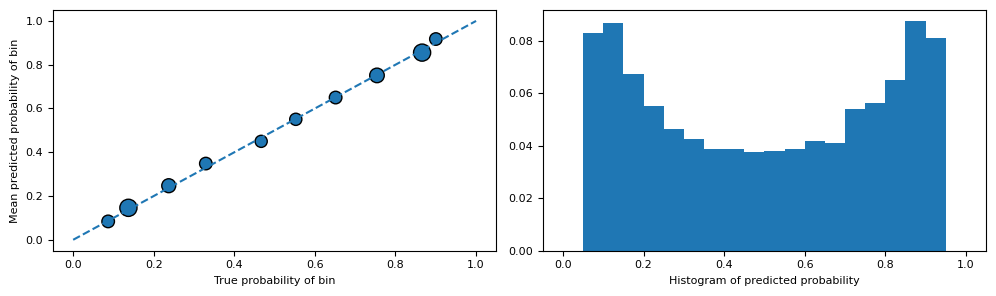

In [8]:
from calibration_stuff import calibration_curve

probs = positivy_assumption_check_estimator.predict_proba(XZ_test)[:, 1]
prob_true, prob_pred, size_bin = calibration_curve(df_test.treatment, probs, n_bins=10)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].plot([0, 1], "--")
ax[0].scatter(prob_true, prob_pred, s=(0.1 * size_bin).astype(int), edgecolor="k")
ax[0].set_xlabel("True probability of bin")
ax[0].set_ylabel("Mean predicted probability of bin")
ax[1].hist(
    probs, bins=np.linspace(0, 1, 21), weights=np.ones_like(probs) / probs.shape[0]
)
ax[1].set_xlabel("Histogram of predicted probability")
plt.tight_layout()

Indeed, after confirming that the model is reasonably calibrated, we can observe that the probability histograms do not contain examples with probabilities close to 0 or 1. This suggests that we are in an appropriate scenario for estimating CATE.

$\oint$ _The scenario of continuous treatment is slightly more complex, but evaluating regression metrics can provide a good intuition of this relationship. Another viable technique is to discretize the treatment and analyze these probabilities in a manner similar to the approach used for the binary case._

___

## Conformalized Quantile Regression

Quantile regression with pinball loss <a href=#bibliography>[7]</a> is a suitable method for predicting conditional quantiles of a target variable. However, these estimates $Q_{\beta}$ and $Q_{1-\beta}$ of the conditional quantiles $\beta \in (0, 1)$ and $1 - \beta$, respectively, usually do not satisfy the coverage property which requires $\mathbb{P}((Y|Z=z) \in (Q_{\beta}$ and $Q_{1-\beta})) \geq 1 - 2 \beta$ <a href=#bibliography>[8]</a>.

Conformalized Quantile Regression utilizes the previous quantile regression approach, but with a correction in these predictions of conditional quantiles, thereby ensuring marginal coverage <a href=#bibliography>[1, 8]</a>.

We can implement a version of Conformalized Quantile Regression using the aforementioned strategy, trying to follow the [scikit-learn standards](https://scikit-learn.org/stable/developers/develop.html).

In [9]:
from functools import partial
from lightgbm import LGBMRegressor
from scipy.stats import loguniform
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.utils.validation import check_X_y, check_is_fitted, _check_sample_weight
from statsmodels.stats.weightstats import DescrStatsW

class ConformalizedQuantileRegression(BaseEstimator):
    """
    Conformalized Quantile Regression with LGBMRegressor.

    This estimator provides prediction intervals for one dimension
    regression tasks by using CQR with LightGBM.

    Parameters
    ----------
    alpha : float, default=0.05
        Determines the size of the prediction interval. For example,
        alpha=0.05 results in a 95% coverage prediction interval.

    calibration_size : float, default=0.2
        The proportion of the dataset to be used for the calibration set
        which computes the conformity scores.

    random_state : int, RandomState instance or None, default=None
        Controls the randomness for reproducibility.

    n_iter_cv : int, default=10
        Number of parameter settings that are sampled in RandomizedSearchCV
        for the LightGBM model during fit.
    """

    def __init__(
        self, alpha=0.05, calibration_size=0.2, random_state=None, n_iter_cv=10
    ):
        self.alpha = alpha
        self.calibration_size = calibration_size
        self.random_state = random_state
        self.n_iter_cv = n_iter_cv

    def _quantile_loss(self, y_true, y_pred, quantile=None, sample_weights=None):
        weighted_errors = (y_true - y_pred) * (quantile - (y_true < y_pred))
        if sample_weights is not None:
            weighted_errors *= sample_weights
        return np.mean(weighted_errors)

    def _return_quantile_model(self, quantile):
        quantile_scorer = make_scorer(
            partial(self._quantile_loss, quantile=quantile), greater_is_better=False
        )

        return RandomizedSearchCV(
            estimator=LGBMRegressor(
                random_state=self.random_state, objective="quantile", alpha=quantile
            ),
            cv=KFold(shuffle=True, random_state=self.random_state),
            param_distributions={
                "learning_rate": loguniform.rvs(
                    random_state=self.random_state, a=0.0001, b=1, size=1000
                ),
                "n_estimators": [50, 100, 200],
                "num_leaves": [31, 63, 127],
            },
            scoring=quantile_scorer,
            n_iter=self.n_iter_cv,
            random_state=self.random_state,
            n_jobs=-1,
        )

    def fit(self, X, y, sample_weight=None):
        X, y = check_X_y(X, y)
        sample_weight = _check_sample_weight(sample_weight, X)

        (
            X_train,
            X_cal,
            y_train,
            y_cal,
            sample_weight_train,
            sample_weight_cal,
        ) = train_test_split(
            X,
            y,
            sample_weight,
            test_size=self.calibration_size,
            random_state=self.random_state,
        )

        self.model_lower_ = self._return_quantile_model(quantile=self.alpha / 2).fit(
            X_train, y_train, sample_weight=sample_weight_train
        )
        self.model_upper_ = self._return_quantile_model(
            quantile=1 - self.alpha / 2
        ).fit(X_train, y_train, sample_weight=sample_weight_train)

        self.y_cal_conformity_scores_ = np.maximum(
            self.model_lower_.predict(X_cal) - y_cal,
            y_cal - self.model_upper_.predict(X_cal),
        )
        wq = DescrStatsW(data=self.y_cal_conformity_scores_, weights=sample_weight_cal)
        self.quantile_conformity_scores_ = wq.quantile(
            probs=1 - self.alpha, return_pandas=False
        )[0]

        return self

    def predict(self, X):
        """
        Predicts conformalized quantile regression intervals for X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y_test_interval_pred_cqr : ndarray of shape (n_samples, 2)
            Returns the predicted lower and upper bound for each sample in X.
        """
        check_is_fitted(self)
        y_test_interval_pred_cqr = np.column_stack(
            [
                self.model_lower_.predict(X) - self.quantile_conformity_scores_,
                self.model_upper_.predict(X) + self.quantile_conformity_scores_,
            ]
        )
        return y_test_interval_pred_cqr

___

## Using the T-learner

In this example, we will utilize the T-learner technique <a href=#bibliography>[3, 9]</a>, building a model to estimate each $\mathbb{E}(Y|do(T=t), Z)$ for $t\in\{0, 1\}$. We will set `alpha=0.05` to construct prediction sets with 95% coverage.

In [10]:
model_t0 = ConformalizedQuantileRegression(
    random_state=42, alpha=0.05, n_iter_cv=30
).fit(XZ_train_t0, y_train_t0)
y_test_interval_pred_cqr_t0 = model_t0.predict(XZ_test)

model_t1 = ConformalizedQuantileRegression(
    random_state=42, alpha=0.05, n_iter_cv=30
).fit(XZ_train_t1, y_train_t1)
y_test_interval_pred_cqr_t1 = model_t1.predict(XZ_test)

$\oint$ _It's worth noting that you may want to implement an importance weighting strategy here to achieve a better prediction set in regions where $P(T=t | Z=z)$ is close to zero (naturally, these being regions with fewer examples). However, if you can ensure the positivity assumption, it may be less critical (especially with models that don't underfit, such as tree ensembles <a href=#bibliography>[10]</a>)._

In [11]:
def return_sample_weight_treatment_i(df_train, df_test):
    df_ood_ti = pd.concat(
        [
            df.assign(train_or_test=j)
            for j, df in enumerate(
                [
                    df_train.drop(columns=["treatment", "target_cf"]),
                    df_test.drop(columns=["treatment", "target_cf"]),
                ]
            )
        ]
    )

    ood_sample_correction_ti = LogisticRegression(
        random_state=42,
    ).fit(df_ood_ti.drop(columns=["train_or_test"]), df_ood_ti.train_or_test)

    roc = roc_auc_score(
        df_ood_ti.train_or_test,
        ood_sample_correction_ti.predict_proba(
            df_ood_ti.drop(columns=["train_or_test"])
        )[:, 1],
    )

    probs = ood_sample_correction_ti.predict_proba(
        df_train.drop(columns=["treatment", "target_cf"])
    )
    # Equivalent to `probs[:, 1]/probs[:, 0]`.
    sample_weights_ti = 1 / probs[:, 0] - 1

    return roc, sample_weights_ti

_, sw_0 = return_sample_weight_treatment_i(df_train=df_train_t0, df_test=df_test)

___

## Evaluating the conformal regression

With the interval estimates calculated in `y_test_interval_pred_cqr_t0` and `y_test_interval_pred_cqr_t1`, we can assess the effectiveness of our predictions. To do this, we will examine factors such as the coverage of our predictions, in both the observational and counterfactual scenarios (given that we also have this value for evaluation) and the size of these intervals.

In [12]:
df_val = (
    df_test.assign(pred_lower_t_0=y_test_interval_pred_cqr_t0[:, 0])
    .assign(pred_upper_t_0=y_test_interval_pred_cqr_t0[:, 1])
    .assign(ic_size_t_0=lambda df_: df_.pred_upper_t_0 - df_.pred_lower_t_0)
    .assign(pred_lower_t_1=y_test_interval_pred_cqr_t1[:, 0])
    .assign(pred_upper_t_1=y_test_interval_pred_cqr_t1[:, 1])
    .assign(ic_size_t_1=lambda df_: df_.pred_upper_t_1 - df_.pred_lower_t_1)
    .assign(
        prob=lambda df_: positivy_assumption_check_estimator.predict_proba(
            df_.filter(backdoor_set)
        )[:, 1]
    )
    .assign(prob_cut=lambda df_: pd.cut(df_.prob, bins=np.linspace(0, 1, 6)))
    .assign(
        coverage=lambda df_: np.select(
            condlist=[df_.treatment == 0],
            choicelist=[
                (df_.target > df_.pred_lower_t_0) & (df_.target < df_.pred_upper_t_0)
            ],
            default=(df_.target > df_.pred_lower_t_1)
            & (df_.target < df_.pred_upper_t_1),
        )
    )
    .assign(
        coverage_cf=lambda df_: np.select(
            condlist=[df_.treatment != 0],
            choicelist=[
                (df_.target_cf > df_.pred_lower_t_0)
                & (df_.target_cf < df_.pred_upper_t_0)
            ],
            default=(df_.target_cf > df_.pred_lower_t_1)
            & (df_.target_cf < df_.pred_upper_t_1),
        )
    )
)

df_val.coverage.mean()

0.9497

It's important to highlight that conformal prediction ensures us a marginal coverage, which doesn't always convert into conditional coverage <a href=#bibliography>[1]</a>. We could be generating excellent estimates for certain regions of $Z$ and inferior ones for the rest and still have good marginal coverage because they would cancel out. To examine this, we would need to study

$$P((Y|Z=z)\in \tau(Z=z) | T=t, Z=z),$$

where $\tau(Z=z)$ is the prediction set for $Z=z$.

One method to visualize this is by partitioning, for instance, the regions using $P(T=1 | Z=z)$ (from the same model as used in the positivity assumption check) to construct buckets where we can calculate coverage estimates, i.e., the mean of $(Y|Z=z)\in \tau(Z=z)$. If we further break it down by treatment, we will be measuring something similar to the conditional coverage.

Using `scipy.stats.bootstrap`, we can estimate confidence intervals for the conditional coverages.

In [13]:
from scipy.stats import bootstrap

def bootstrap_ci(x, ci=0.95):
    boot = bootstrap((x,), np.mean, confidence_level=ci)
    return np.round(boot.confidence_interval, 5)

df_val_cond_aux1 = (
    df_val.groupby(["prob_cut", "treatment"])
    .coverage.apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"coverage": "coverage_confidence_interval"})
)

df_val_cond_aux2 = (
    df_val.groupby(["prob_cut", "treatment"])
    .coverage_cf.apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"coverage_cf": "coverage_cf_confidence_interval"})
)

df_val_cond_aux3 = (
    df_val.groupby(["prob_cut", "treatment"])
    .agg(
        {
            "coverage": np.mean,
            "coverage_cf": np.mean,
            "ic_size_t_0": np.mean,
            "ic_size_t_1": np.mean,
        }
    )
    .rename(columns=lambda col: col + "_mean")
)

pd.concat(
    [df_val_cond_aux1, df_val_cond_aux2, df_val_cond_aux3], axis=1
).reset_index().sort_values(["treatment", "prob_cut"])


,prob_cut,treatment,coverage_confidence_interval,coverage_cf_confidence_interval,coverage_mean,coverage_cf_mean,ic_size_t_0_mean,ic_size_t_1_mean
0,"(0.0, 0.2]",0.0,"[0.93669, 0.95635]","[0.93046, 0.95108]",0.947242,0.941487,1.980407,6.920811
2,"(0.2, 0.4]",0.0,"[0.94852, 0.96972]","[0.93565, 0.95988]",0.959879,0.948524,2.032159,4.205569
4,"(0.4, 0.6]",0.0,"[0.93891, 0.96946]","[0.94024, 0.96946]",0.956175,0.956175,2.054778,2.642784
6,"(0.6, 0.8]",0.0,"[0.92321, 0.96071]","[0.94464, 0.97679]",0.944643,0.962500,1.949311,4.066495
8,"(0.8, 1.0]",0.0,"[0.91579, 0.96842]","[0.92982, 0.97895]",0.947368,0.957895,2.180449,6.671260
1,"(0.0, 0.2]",1.0,"[0.90459, 0.96466]","[0.92226, 0.97527]",0.939929,0.954064,1.985375,6.573730
3,"(0.2, 0.4]",1.0,"[0.8998, 0.94499]","[0.91749, 0.95874]",0.925344,0.941061,2.043951,4.025180
5,"(0.4, 0.6]",1.0,"[0.93103, 0.96296]","[0.93103, 0.96296]",0.948914,0.948914,2.054981,2.636064
7,"(0.6, 0.8]",1.0,"[0.94165, 0.96353]","[0.9329, 0.95697]",0.953319,0.945295,1.973618,4.291990
9,"(0.8, 1.0]",1.0,"[0.94, 0.95902]","[0.94049, 0.95951]",0.950244,0.950732,2.214706,6.862401


Indeed, it appears that we're also doing a reasonable job in terms of our conditional coverage, very close to 95%, the coverage requested from `ConformalizedQuantileRegression`. This implies that even in regions with fewer examples with treatment $T=0$ (for instance, where `prob_cut=[0.8, 1)`), our coverage is fairly substantial.

$\oint$ _Since $P((Y|Z=z)\in \tau(Z=z) | T=t, Z=z)$ shares many characteristics of a classification problem, another viable strategy might be to explore what the probabilistic output of a classifier, tasked with predicting this problem, would resemble._

In [14]:
probs_coverage = (
    LogisticRegression()
    .fit(df_val.filter(["treatment", "confounder"]), df_val.coverage.astype(int))
    .predict_proba(df_val.filter(["treatment", "confounder"]))[:, 1]
)

roc_auc_score(df_val.coverage.astype(int), probs_coverage)

0.5152119817684396

_By executing this, we can observe that the classifier is incapable of identifying regions where there is poor coverage. We can see that the minimum of these estimated conditional probabilities (without extensive verification of calibration) remains reasonably high._

In [15]:
min(probs_coverage), max(probs_coverage)

(0.9405329900858612, 0.9577096822516356)

$\oint$ _It's also common to evaluate the conditional coverage in relation to the size of the predicted interval (partitioning the intervals into "small", "medium", and "large") <a href=#bibliography>[1]</a>. In a real application, I would undertake this, but I wish to avoid overloading this text with code, so the above already illustrates the exercise adequately._

___

## Joining confidence intervals

While our estimates appear to be coherent, what we ultimately aim to estimate is what happens when we subtract the predicted intervals. Combining intervals while maintaining coverage isn't a straightforward task. Let's delve into this scenario a bit more.

Let's assume we have two random variables with given probabilities of being within certain intervals: 
$$\mathbb{P}(A \in (m_a, M_a)) \geq 1 - \alpha, \mathbb{P}(B \in (m_b, M_b)) \geq 1 - \beta.$$

Observe that the intersection of these two events implies that the sum of the random variables lies within the interval derived from the summation of the ends of the intervals. In other words,
$$\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\} \subset  \{A + B \in (m_a + m_b, M_a + M_b)\}.$$

In probability theory, a set contained in another is bounded by the probability of the larger set, so
$$\mathbb{P}(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}) \leq \mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}).$$

From here, let's develop an inequality starting from the left term. The probability of the complement can be calculated as follows:
$$
\begin{align*}
    \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) &= \mathbb{P}(\{A \in (m_a, M_a)\}^C \cup \{ B \in (m_b, M_b)\}^C)\\
    &\leq \mathbb{P}(\{A \in (m_a, M_a)\}^C) + \mathbb{P}(\{ B \in (m_b, M_b)\}^C),
\end{align*}
$$
using De Morgan's laws and an overestimation of the probability of the union as the sum of the probabilities.

Following this, we can conclude that
$$
\begin{align*}
    \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) &\leq 1 - \mathbb{P}(\{A \in (m_a, M_a)\}) + 1 - \mathbb{P}(\{ B \in (m_b, M_b)\}^C)\\
    &\leq 1 - (1 - \alpha) + 1 - (1 - \beta) = \alpha + \beta.
\end{align*}
$$

$\oint$ _This inequality is rude because  $\{A \in (m_a, M_a)\}^C $ and $ \{ B \in (m_b, M_b)\}^C$ have a significant intersection. However, we assume it's zero when we overestimate the probability of the union by the sum of the probabilities (we are presuming they are disjoint intervals)_.

Since 
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) \leq \alpha + \beta,$$
we find
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)) = 1 - \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) \geq 1 - (\alpha + \beta).$$

From this, we can deduce that since
$$\mathbb{P}(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}) \leq  \mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}),$$
we obtain an inequality for the interval resulting from the sum of the ends of the initial intervals:
$$\mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}) \geq 1 - (\alpha + \beta).$$

$\oint$ _This method is generally used in hypothesis testing with a Bonferroni correction derived from Boole's inequality <a href=#bibliography>[11]</a>._

___

## Prediction interval of CATE

In our particular scenario, we are working with $A = \mathbb{E}(Y|do(T=0), Z=z)$ and $B = - \mathbb{E}(Y|do(T=0), Z=z)$. As a result, the limits of the intervals for $B$ are fliped from the ones we have in `y_test_interval_pred_cqr_t0`.

Once again, it would be valuable to assess the coverage and size of the intervals that we have now created.

In [16]:
df_val_cate = (
    df_val.assign(
        cate_actual=lambda df_: np.select(
            condlist=[(df_.treatment == 0)],
            choicelist=[df_.target_cf - df_.target],
            default=[df_.target - df_.target_cf],
        )[0]
    )
    .assign(cate_ci_lower=lambda df_: df_.pred_lower_t_1 - df_.pred_upper_t_0)
    .assign(cate_ci_upper=lambda df_: df_.pred_upper_t_1 - df_.pred_lower_t_0)
    .assign(cate_ci_size=lambda df_: df_.cate_ci_upper - df_.cate_ci_lower)
    .assign(
        coverage_cate=lambda df_: (df_.cate_actual > df_.cate_ci_lower)
        & (df_.cate_actual < df_.cate_ci_upper)
    )
)

As expected, the prediction intervals are larger than the ones found earlier.

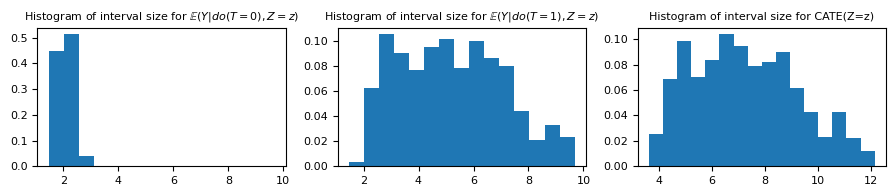

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 2))
aux_hist = np.hstack([df_val.ic_size_t_0, df_val.ic_size_t_1])
min_hist, max_hist = np.min(aux_hist), np.max(aux_hist)
ax[0].hist(
    df_val.ic_size_t_0,
    bins=np.linspace(min_hist, max_hist, 16),
    weights=np.ones_like(df_val.ic_size_t_0) / df_val.shape[0],
)
ax[1].hist(
    df_val.ic_size_t_1,
    bins=np.linspace(min_hist, max_hist, 16),
    weights=np.ones_like(df_val.ic_size_t_1) / df_val.shape[0],
)
ax[2].hist(
    df_val_cate.cate_ci_size,
    bins=16,
    weights=np.ones_like(df_val_cate.cate_ci_size) / df_val_cate.shape[0],
)
ax[0].set_title(
    "Histogram of interval size for $\mathbb{E}(Y | do(T=0), Z=z)$", fontsize="medium"
)
ax[1].set_title(
    "Histogram of interval size for $\mathbb{E}(Y | do(T=1), Z=z)$", fontsize="medium"
)
ax[2].set_title("Histogram of interval size for CATE(Z=z)", fontsize="medium")
plt.tight_layout()

Even though our individual prediction intervals were constructed for a coverage of $1 - \alpha = 0.9$, our prediction intervals for the CATE should only be $1 - (0.1 + 0.1) = 0.8$. However, as we discussed before, this is a rude approximation, and the actual coverage is substantially better than that.

In [18]:
df_val_cate.coverage_cate.mean()

0.9997

Given that we are dealing with $Z\in\mathbb{R}$, we can visually evaluate our conformal estimator by plotting the prediction intervals for the meta-estimators and for our estimate of the CATE. In addition, since we have control over the noise variance, we can also plot the real 95% confidence interval.

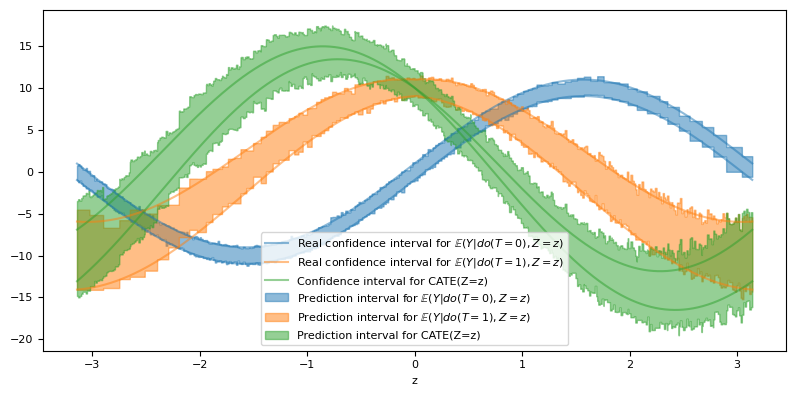

In [19]:
confouder_plot = np.linspace(XZ_test.confounder.min(), XZ_test.confounder.max(), 10_001)
ci_t1_plot = model_t1.predict(confouder_plot.reshape(-1, 1)).T
ci_t0_plot = model_t0.predict(confouder_plot.reshape(-1, 1)).T
ci_cate_plot = ci_t1_plot - ci_t0_plot[::-1,]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    confouder_plot,
    func_0(confouder_plot) + 1.96 * 0.5,
    alpha=0.5,
    c="C0",
    label="Real confidence interval for $\mathbb{E}(Y | do(T=0), Z=z)$",
)
ax.plot(confouder_plot, func_0(confouder_plot) - 1.96 * 0.5, alpha=0.5, c="C0")

ax.plot(
    confouder_plot,
    func_1(confouder_plot) + 1.96 * (0.5 * (1 + np.abs(confouder_plot))),
    alpha=0.5,
    c="C1",
    label="Real confidence interval for $\mathbb{E}(Y | do(T=1), Z=z)$",
)
ax.plot(
    confouder_plot,
    func_1(confouder_plot) - 1.96 * (0.5 * (1 + np.abs(confouder_plot))),
    alpha=0.5,
    c="C1",
)

# Variance of CATE(Z=z) is 0.5 * |z| because the term
# related to 1 u_Y is annulled when we do
# \mathbb{E}(g_Y(u_Y, z, 1)) - \mathbb{E}(g_Y(u_Y, z, 0)).
ax.plot(
    confouder_plot,
    func_1(confouder_plot)
    - func_0(confouder_plot)
    + 1.96 * (0.5 * (np.abs(confouder_plot))),
    alpha=0.5,
    c="C2",
    label="Confidence interval for CATE(Z=z)",
)
ax.plot(
    confouder_plot,
    func_1(confouder_plot)
    - func_0(confouder_plot)
    - 1.96 * (0.5 * (np.abs(confouder_plot))),
    alpha=0.5,
    c="C2",
)

ax.fill_between(
    confouder_plot,
    *ci_t0_plot,
    alpha=0.5,
    label="Prediction interval for $\mathbb{E}(Y | do(T=0), Z=z)$",
    color="C0",
)
ax.fill_between(
    confouder_plot,
    *ci_t1_plot,
    alpha=0.5,
    label="Prediction interval for $\mathbb{E}(Y | do(T=1), Z=z)$",
    color="C1",
)
ax.fill_between(
    confouder_plot,
    *ci_cate_plot,
    alpha=0.5,
    label="Prediction interval for CATE(Z=z)",
    color="C2",
)

ax.set_xlabel("z")
ax.legend()
plt.tight_layout()

In fact, all our prediction intervals seem to align closely with the theoretical value of the confidence intervals, with the exception of the CATE interval, where we are overestimating it.

___

## Final considerations

The CATE is an extremely interesting quantity to have in various scenarios of applied causal inference. The ability to integrate the concepts of conformal prediction into CATE estimation serves as a powerful tool, ensuring that we leverage the full potential of uncertainty quantification in our analyses and decisions. In this exploration, Conformalized Quantile Regression demonstrated its aptitude as a robust method for estimating the CATE while also offering reliable uncertainty quantification despite some overestimation.

## <a name="bibliography">Bibliography</a>

[1] [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification. Anastasios N. Angelopoulos, Stephen Bates.](http://people.eecs.berkeley.edu/~angelopoulos/blog/posts/gentle-intro/)

[2] [Class notes on Causal Inference (PTBR). Rafael Bassi Stern.](https://github.com/rbstern/causality_book/blob/435e920d7d68872fea1be187b0dcf6c5e8b3a55e/book.pdf)

[3] [Causal Inference for The Brave and True. Matheus Facure](https://matheusfacure.github.io/python-causality-handbook/landing-page.html)

[4] [Causal Inference Course. Brady Neal.](https://youtube.com/playlist?list=PLoazKTcS0RzZ1SUgeOgc6SWt51gfT80N0)

[5] [Causal Inference on Observational Data: It's All About the Assumptions. Jean-Yves Gérardy.](https://matheusfacure.github.io/python-causality-handbook/landing-page.html)

[6] [Probability calibration. Scikit-Learn User Guide.](https://scikit-learn.org/stable/modules/calibration.html)

[7] [Estimating conditional quantiles with the help of the pinball loss. Ingo Steinwart, Andreas Christmann.](https://arxiv.org/abs/1102.2101)

[8] [How to Predict Risk-Proportional Intervals with Conformal Quantile Regression. Samuele Mazzanti.](https://towardsdatascience.com/how-to-predict-risk-proportional-intervals-with-conformal-quantile-regression-175775840dc4)

[9] [T-learners, S-learners and X-learners. Statistical Odds & Ends.](https://statisticaloddsandends.wordpress.com/2022/05/20/t-learners-s-learners-and-x-learners/)

[10] [Analysis of Kernel Mean Matching under Covariate Shift. Yaoliang Yu, Csaba Szepesvari.](https://matheusfacure.github.io/python-causality-handbook/landing-page.html)

[11] [Bonferroni correction. Wikipedia.](https://en.wikipedia.org/wiki/Bonferroni_correction)